# Structured Data Assignment

## Description of the dataset
The dataset in question contains a comprehensive collection of electronic health records belonging to patients who have been diagnosed with a specific disease. These health records comprise a detailed log of every aspect of the patients' medical history, including all diagnoses, symptoms, prescribed drug treatments, and medical tests that they have undergone. Each row represents a healthcare record/medical event for a patient and it includes a timestamp for each entry/event, thereby allowing for a chronological view of the patient's medical history The Data has mainly three columns

Patient-Uid - Unique Alphanumeric Identifier for a patient
Date - Date when patient encountered the event.
Incident - This columns describes which event occurred on the day.

### Problem Statement
The development of drugs is critical in providing therapeutic options for patients suffering from chronic and terminal illnesses. “Target Drug”, in particular, is designed to enhance the patient's health and well-being without causing dependence on other medications that could potentially lead to severe and life-threatening side effects. These drugs are specifically tailored to treat a particular disease or condition, offering a more focused and effective approach to treatment, while minimising the risk of harmful reactions. The objective in this assignment is to develop a predictive model which will predict whether a patient will be eligible*** for “Target Drug” or not in next 30 days. Knowing if the patient is eligible or not will help physician treating the patient make informed decision on the which treatments to give.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install lightgbm

     ---------------------------------------- 1.3/1.3 MB 2.3 MB/s eta 0:00:00


In [5]:
##importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta,datetime
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,f1_score,roc_auc_score,auc,accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [6]:
#Loading dataset
train_df = pd.read_parquet('train.parquet')

In [7]:
train_df.head(5)

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1


In [8]:
train_df.tail(5)

,Patient-Uid,Date,Incident
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6
29080911,a0ee146e-1c7c-11ec-baee-16262ee38c7f,2018-10-05,DRUG_TYPE_1


In [9]:
train_df.shape

(3220868, 3)

We can see that there are 3220868 rows and 3 columns

In [10]:
#columns
train_df.columns

Index(['Patient-Uid', 'Date', 'Incident'], dtype='object')

In [11]:
#dataset description
train_df.describe()

,Patient-Uid,Date,Incident
count,3220868,3220868,3220868
unique,27033,1977,57
top,a0ddfd2c-1c7c-11ec-876d-16262ee38c7f,2019-05-21 00:00:00,DRUG_TYPE_6
freq,1645,3678,561934
first,NaN,2015-04-07 00:00:00,NaN
last,NaN,2020-09-03 00:00:00,NaN


### Data Preprocessing

#### Finding duplicates

In [13]:
train_df.duplicated().sum()

35571

In [14]:
#dropping all duplicates
train_df = train_df.drop_duplicates()

In [15]:
train_df.duplicated().sum()

0

In [16]:
train_df.dtypes

Patient-Uid            object
Date           datetime64[ns]
Incident               object
dtype: object

#### Missing Values

In [17]:
train_df.isnull().sum()

Patient-Uid    0
Date           0
Incident       0
dtype: int64

#### Unique values 

In [18]:
print(train_df['Incident'].unique())

['PRIMARY_DIAGNOSIS' 'SYMPTOM_TYPE_0' 'DRUG_TYPE_0' 'DRUG_TYPE_1'
 'DRUG_TYPE_2' 'TEST_TYPE_0' 'DRUG_TYPE_3' 'DRUG_TYPE_4' 'DRUG_TYPE_5'
 'DRUG_TYPE_6' 'DRUG_TYPE_8' 'DRUG_TYPE_7' 'SYMPTOM_TYPE_1' 'DRUG_TYPE_10'
 'SYMPTOM_TYPE_29' 'SYMPTOM_TYPE_2' 'DRUG_TYPE_11' 'DRUG_TYPE_9'
 'DRUG_TYPE_13' 'SYMPTOM_TYPE_5' 'TEST_TYPE_1' 'SYMPTOM_TYPE_6'
 'TEST_TYPE_2' 'SYMPTOM_TYPE_3' 'SYMPTOM_TYPE_8' 'DRUG_TYPE_14'
 'DRUG_TYPE_12' 'SYMPTOM_TYPE_9' 'SYMPTOM_TYPE_10' 'SYMPTOM_TYPE_7'
 'SYMPTOM_TYPE_11' 'TEST_TYPE_3' 'DRUG_TYPE_15' 'SYMPTOM_TYPE_4'
 'SYMPTOM_TYPE_14' 'SYMPTOM_TYPE_13' 'SYMPTOM_TYPE_16' 'SYMPTOM_TYPE_17'
 'SYMPTOM_TYPE_15' 'SYMPTOM_TYPE_18' 'SYMPTOM_TYPE_12' 'SYMPTOM_TYPE_20'
 'SYMPTOM_TYPE_21' 'DRUG_TYPE_17' 'SYMPTOM_TYPE_22' 'TEST_TYPE_4'
 'SYMPTOM_TYPE_23' 'DRUG_TYPE_16' 'TEST_TYPE_5' 'SYMPTOM_TYPE_19'
 'SYMPTOM_TYPE_24' 'SYMPTOM_TYPE_25' 'SYMPTOM_TYPE_26' 'SYMPTOM_TYPE_27'
 'DRUG_TYPE_18' 'SYMPTOM_TYPE_28' 'TARGET DRUG']


In [19]:
train_df.Date.value_counts()

2019-05-21    3645
2019-05-22    3330
2019-03-05    3156
2019-05-14    3134
2019-03-12    2986
              ... 
2017-01-27     308
2017-02-28     285
2020-02-29     282
2016-01-29     271
2016-02-29     255
Name: Date, Length: 1977, dtype: int64

In [20]:
train_df.Incident.value_counts()

DRUG_TYPE_6          549616
DRUG_TYPE_1          484565
PRIMARY_DIAGNOSIS    424879
DRUG_TYPE_0          298881
DRUG_TYPE_2          256203
DRUG_TYPE_7          251239
DRUG_TYPE_8          158706
DRUG_TYPE_3          126615
TEST_TYPE_1           96810
TARGET DRUG           67218
DRUG_TYPE_9           66894
DRUG_TYPE_5           55940
SYMPTOM_TYPE_0        46078
DRUG_TYPE_11          45419
SYMPTOM_TYPE_6        32066
TEST_TYPE_0           27570
SYMPTOM_TYPE_7        22019
DRUG_TYPE_10          20911
DRUG_TYPE_14          17306
DRUG_TYPE_13          12321
DRUG_TYPE_12           9540
SYMPTOM_TYPE_14        8927
SYMPTOM_TYPE_1         8608
SYMPTOM_TYPE_2         8168
TEST_TYPE_3            8115
SYMPTOM_TYPE_5         7583
SYMPTOM_TYPE_8         7430
TEST_TYPE_2            7021
SYMPTOM_TYPE_15        6295
SYMPTOM_TYPE_10        6005
SYMPTOM_TYPE_29        5910
SYMPTOM_TYPE_16        4940
DRUG_TYPE_15           4906
SYMPTOM_TYPE_9         4885
DRUG_TYPE_4            4566
SYMPTOM_TYPE_4      

### For Developing the model,¶
we Come up with a positive and negative set for developing the model, here the positive point is the patient who has taken ‘Target Drug”. so we also taking into account the time aspect while coming up with a positive & negative set because the aim is to predict 30 days in advance whether a patient is going to be eligible or not.

In [21]:
positive_df = train_df[train_df['Incident'] == 'TARGET DRUG']
positive_df.head()

,Patient-Uid,Date,Incident
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG


In [22]:
positive_df.shape

(67218, 3)

In [23]:
negative = ~train_df['Patient-Uid'].isin(positive_df['Patient-Uid'])
negative_df = train_df[negative].groupby('Patient-Uid').tail(1)
negative_df.head()

,Patient-Uid,Date,Incident
1560892,a0e3a8c0-1c7c-11ec-98c2-16262ee38c7f,2018-05-06,PRIMARY_DIAGNOSIS
1620903,a0dd6a3f-1c7c-11ec-9b86-16262ee38c7f,2015-04-07,SYMPTOM_TYPE_0
1629044,a0e48a75-1c7c-11ec-8c5f-16262ee38c7f,2018-08-22,DRUG_TYPE_6
1942882,a0e3cf61-1c7c-11ec-8098-16262ee38c7f,2018-08-21,DRUG_TYPE_2
1975541,a0e91a8c-1c7c-11ec-acc2-16262ee38c7f,2020-04-15,PRIMARY_DIAGNOSIS


In [24]:
negative_df.shape

(17659, 3)

In [25]:
#to get count of previous prescription within specific time 
positive_df = positive_df.copy()
negative_df = negative_df.copy()
positive_df['Prescription-count'] = positive_df.groupby('Patient-Uid')['Date'].cumcount()
negative_df['Prescription-count'] = negative_df.groupby('Patient-Uid')['Date'].cumcount()

In [27]:
positive_df.tail()

,Patient-Uid,Date,Incident,Prescription-count
29074998,a0ef2b6d-1c7c-11ec-9172-16262ee38c7f,2018-10-12,TARGET DRUG,4
29075105,a0ebe423-1c7c-11ec-a5e0-16262ee38c7f,2019-07-02,TARGET DRUG,9
29075494,a0ebc713-1c7c-11ec-bd53-16262ee38c7f,2019-05-21,TARGET DRUG,10
29080031,a0ee1bdb-1c7c-11ec-90ba-16262ee38c7f,2018-06-07,TARGET DRUG,14
29080178,a0eef180-1c7c-11ec-8de8-16262ee38c7f,2018-07-17,TARGET DRUG,13


In [28]:
negative_df.tail()

,Patient-Uid,Date,Incident,Prescription-count
3256795,a0e045a1-1c7c-11ec-8014-16262ee38c7f,2020-07-10,PRIMARY_DIAGNOSIS,0
3256799,a0e67e2a-1c7c-11ec-b805-16262ee38c7f,2015-12-16,PRIMARY_DIAGNOSIS,0
3256800,a0dec400-1c7c-11ec-80df-16262ee38c7f,2019-08-06,PRIMARY_DIAGNOSIS,0
3256804,a0e09919-1c7c-11ec-9e7d-16262ee38c7f,2017-02-19,DRUG_TYPE_6,0
3256805,a0e69331-1c7c-11ec-a98d-16262ee38c7f,2015-10-03,DRUG_TYPE_6,0


In [29]:
#Time difference btween most recent prescription and the prediction date
predication_date = pd.to_datetime('today') + pd.DateOffset(days=30)
positive_df['Time_difference'] = (predication_date - positive_df.groupby('Patient-Uid')['Date'].transform('max')).dt.days
negative_df['Time_difference'] = (predication_date - negative_df.groupby('Patient-Uid')['Date'].transform('max')).dt.days
positive_df.head()

,Patient-Uid,Date,Incident,Prescription-count,Time_difference
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG,0,1197
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG,0,1451
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG,0,1476
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG,0,1181
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG,0,1197


In [30]:
negative_df.head()

,Patient-Uid,Date,Incident,Prescription-count,Time_difference
1560892,a0e3a8c0-1c7c-11ec-98c2-16262ee38c7f,2018-05-06,PRIMARY_DIAGNOSIS,0,2027
1620903,a0dd6a3f-1c7c-11ec-9b86-16262ee38c7f,2015-04-07,SYMPTOM_TYPE_0,0,3152
1629044,a0e48a75-1c7c-11ec-8c5f-16262ee38c7f,2018-08-22,DRUG_TYPE_6,0,1919
1942882,a0e3cf61-1c7c-11ec-8098-16262ee38c7f,2018-08-21,DRUG_TYPE_2,0,1920
1975541,a0e91a8c-1c7c-11ec-acc2-16262ee38c7f,2020-04-15,PRIMARY_DIAGNOSIS,0,1317


In [31]:
#creating a df with both positive and negative sets
df = pd.concat([positive_df,negative_df])
df.head()

,Patient-Uid,Date,Incident,Prescription-count,Time_difference
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG,0,1197
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG,0,1451
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG,0,1476
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG,0,1181
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG,0,1197


In [33]:
df.shape

(84877, 5)

In [34]:
# 1 for Target drug , 0 for others

df['Target'] = np.where(df['Incident'] == 'TARGET DRUG',1,0)
df.head()

,Patient-Uid,Date,Incident,Prescription-count,Time_difference,Target
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG,0,1197,1
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG,0,1451,1
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG,0,1476,1
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG,0,1181,1
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG,0,1197,1


## Train and Test Split

In [53]:
#splitting the dataset into traIn and test sets
x_train,x_test,y_train,y_test =  train_test_split(df[['Prescription-count','Time_difference']],df['Incident'] == 'TARGET DRUG',test_size = 0.2)

In [54]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((67901, 2), (67901,), (16976, 2), (16976,))

## Model Selection

### Random Forest Classifier

In [55]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [56]:
#predicting test data
y_pred = rf.predict(x_test)

In [57]:
#confusion matrix to evaluate the model
confusion_matrix_report = confusion_matrix(y_test,y_pred)
confusion_matrix_report

array([[ 3020,   440],
       [  591, 12925]], dtype=int64)

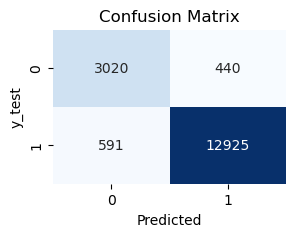

              precision    recall  f1-score   support

       False       0.84      0.87      0.85      3460
        True       0.97      0.96      0.96     13516

    accuracy                           0.94     16976
   macro avg       0.90      0.91      0.91     16976
weighted avg       0.94      0.94      0.94     16976



In [58]:
plt.figure(figsize=(3,2))
sns.heatmap(confusion_matrix_report,annot=True,fmt = 'd', cmap = 'Blues', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('y_test')
plt.title('Confusion Matrix')
plt.show()

#classification_report

print(classification_report(y_test,y_pred))

In [59]:
#f1 Score
rf_f1 = f1_score(y_test,y_pred)
print(f"Random forest f1_score is {rf_f1}")
#accuracy
rf_accuracy = accuracy_score(y_test,y_pred)
print(f"Random Forest accuracy_score is {rf_accuracy}")

Random forest f1_score is 0.9616457721066924
Random Forest accuracy_score is 0.9392672007540056


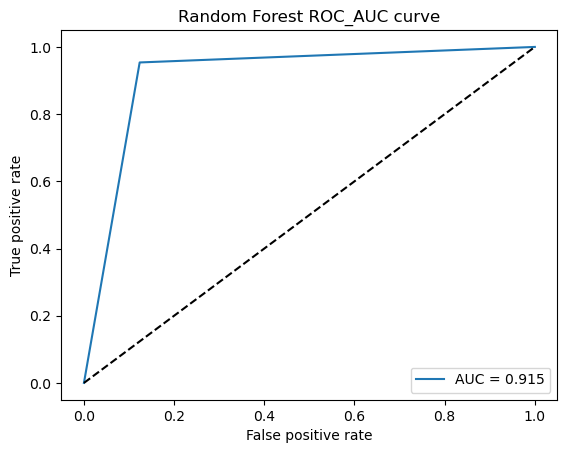

Random Forest ROC-AUC Score: 0.9150978610420496


In [44]:
#roc_auc curve

fpr,tpr, thresold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr, label = 'AUC = %0.3f' % roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.title('Random Forest ROC_AUC curve')
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


rf_roc_auc = roc_auc_score(y_test, y_pred)
print("Random Forest ROC-AUC Score:", rf_roc_auc)


### XGBoost Classifier

In [60]:
#using XGB model to train the data
xgb_classifier = XGBClassifier(random_state = 42)
xgb_classifier.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [61]:
#predicitng data
y_pred = xgb_classifier.predict(x_test)

In [62]:
#confusion matrix to evaluate the model
xgb_confusion_matrix = confusion_matrix(y_test,y_pred)
xgb_confusion_matrix

array([[ 3155,   305],
       [  699, 12817]], dtype=int64)

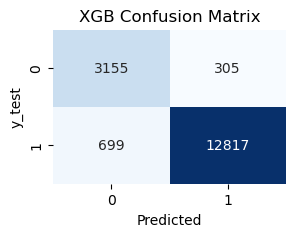

              precision    recall  f1-score   support

       False       0.82      0.91      0.86      3460
        True       0.98      0.95      0.96     13516

    accuracy                           0.94     16976
   macro avg       0.90      0.93      0.91     16976
weighted avg       0.94      0.94      0.94     16976



In [63]:
plt.figure(figsize=(3,2))
sns.heatmap(xgb_confusion_matrix,annot=True,fmt = 'd', cmap = 'Blues', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('y_test')
plt.title('XGB Confusion Matrix')
plt.show()

#classification_report

print(classification_report(y_test,y_pred))

In [64]:
#f1 Score
xgb_f1 = f1_score(y_test,y_pred)
print(f"f1_score is {xgb_f1}")
#accuracy
xgb_accuracy = accuracy_score(y_test,y_pred)
print(f"accuracy_score is {xgb_accuracy}")

f1_score is 0.9623094826938958
accuracy_score is 0.9408576814326107


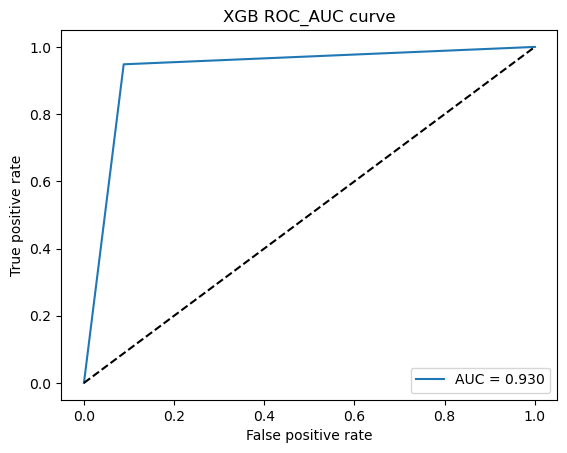

ROC-AUC Score: 0.9300666134078728


In [65]:
#roc_auc curve

fpr,tpr, thresold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr, label = 'AUC = %0.3f' % roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.title('XGB ROC_AUC curve')
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


xgb_roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC Score:", xgb_roc_auc)

### LGBM Classifier

In [70]:
pip install --upgrade lightgbm


Note: you may need to restart the kernel to use updated packages.


In [87]:
lgbm_model = LGBMClassifier()
lgbm_model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 53702, number of negative: 14199
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297
[LightGBM] [Info] Number of data points in the train set: 67901, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.790887 -> initscore=1.330279
[LightGBM] [Info] Start training from score 1.330279


LGBMClassifier()

In [88]:
lgbm_pred = lgbm_model.predict(x_test)

In [89]:
#confusion matrix to evaluate the model
lgbm_confusion_matrix = confusion_matrix(y_test,lgbm_pred)
lgbm_confusion_matrix

array([[ 3178,   282],
       [  720, 12796]], dtype=int64)

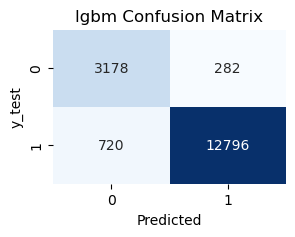

              precision    recall  f1-score   support

       False       0.82      0.92      0.86      3460
        True       0.98      0.95      0.96     13516

    accuracy                           0.94     16976
   macro avg       0.90      0.93      0.91     16976
weighted avg       0.95      0.94      0.94     16976



In [90]:
plt.figure(figsize=(3,2))
sns.heatmap(lgbm_confusion_matrix,annot=True,fmt = 'd', cmap = 'Blues', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('y_test')
plt.title('lgbm Confusion Matrix')
plt.show()

#classification_report

print(classification_report(y_test,lgbm_pred))

In [91]:
# Evaluate the model performance
lgbm_accuracy = accuracy_score(y_test, lgbm_pred)
print(f"LightGBM Accuracy: {lgbm_accuracy}")

lgbm_f1score = f1_score(y_test, lgbm_pred)
print(f"LightGBM f1 Score: {lgbm_f1score}")

LightGBM Accuracy: 0.9409754948162111
LightGBM f1 Score: 0.9623223283447393


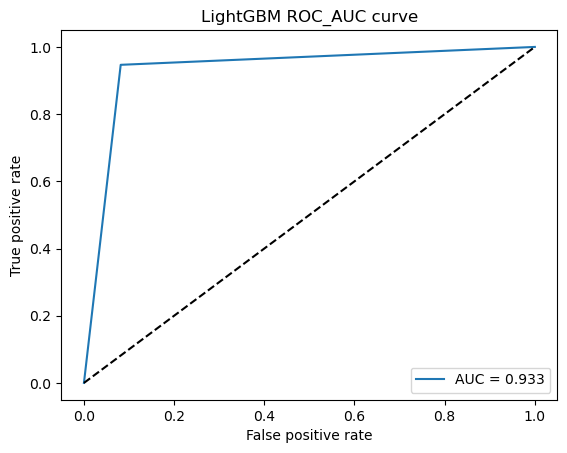

lgbm ROC-AUC Score: 0.932613455771537


In [92]:
#roc_auc curve

fpr,tpr, thresold = roc_curve(y_test, lgbm_pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr, label = 'AUC = %0.3f' % roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.title('LightGBM ROC_AUC curve')
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


lgbm_roc_auc = roc_auc_score(y_test, lgbm_pred)
print("lgbm ROC-AUC Score:", lgbm_roc_auc)

### Evaluation metrics

In [95]:
print(f"f1 Score for Random forest : {rf_f1}")
print(f"f1 Score for XGBoost : {xgb_f1}")
print(f"f1 Score for LightGBM : {lgbm_f1score}")

f1 Score for Random forest : 0.9616457721066924
f1 Score for XGBoost : 0.9623094826938958
f1 Score for LightGBM : 0.9623223283447393


In [96]:
print(f"ROC_AUC Score for Random forest : {rf_roc_auc}")
print(f"ROC_AUC for XGBoost : {xgb_roc_auc}")
print(f"ROC_AUC for LightGBM : {lgbm_roc_auc}")

ROC_AUC Score for Random forest : 0.9150978610420496
ROC_AUC for XGBoost : 0.9300666134078728
ROC_AUC for LightGBM : 0.932613455771537


## Loading Test dataset

In [97]:
test_df = pd.read_parquet('test.parquet')
test_df.shape

(1065524, 3)

In [99]:
#Data Cleaning and preprocessing

#test_df.head()
test_df.duplicated().sum()

12100

In [101]:
test_df = test_df.drop_duplicates()
test_df.duplicated().sum()

0

In [102]:
positive_tdf = test_df[test_df['Incident'] == 'TARGET DRUG']
positive_tdf.head()

,Patient-Uid,Date,Incident


In [103]:
positive_tdf.shape

(0, 3)

In [104]:
negativet = ~test_df['Patient-Uid'].isin(positive_tdf['Patient-Uid'])
negative_tdf = test_df[negativet].groupby('Patient-Uid').tail(1)
negative_tdf.head(5)

,Patient-Uid,Date,Incident
57,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,TEST_TYPE_0
208,a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,2016-06-22,DRUG_TYPE_9
305,a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,2019-07-21,DRUG_TYPE_6
420,a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,2016-06-15,DRUG_TYPE_6
497,a0f9eab1-1c7c-11ec-a732-16262ee38c7f,2018-11-22,DRUG_TYPE_6


In [105]:
negative_tdf.shape

(11482, 3)

In [106]:
#to get count of previous prescription within specific time 
positive_tdf = positive_tdf.copy()
negative_tdf = negative_tdf.copy()
positive_tdf['Prescription-count'] = positive_tdf.groupby('Patient-Uid')['Date'].cumcount()
negative_tdf['Prescription-count'] = negative_tdf.groupby('Patient-Uid')['Date'].cumcount()


In [108]:
#Time difference btween most recent prescription and the prediction date
predication_date = pd.to_datetime('today') + pd.DateOffset(days=30)
positive_tdf['Time_difference'] = (predication_date - positive_tdf.groupby('Patient-Uid')['Date'].transform('max')).dt.days
negative_tdf['Time_difference'] = (predication_date - negative_tdf.groupby('Patient-Uid')['Date'].transform('max')).dt.days

In [109]:
positive_tdf.head()

,Patient-Uid,Date,Incident,Prescription-count,Time_difference


In [111]:
negative_tdf.head()

,Patient-Uid,Date,Incident,Prescription-count,Time_difference
57,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,TEST_TYPE_0,0,2183
208,a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,2016-06-22,DRUG_TYPE_9,0,2710
305,a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,2019-07-21,DRUG_TYPE_6,0,1586
420,a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,2016-06-15,DRUG_TYPE_6,0,2717
497,a0f9eab1-1c7c-11ec-a732-16262ee38c7f,2018-11-22,DRUG_TYPE_6,0,1827


In [112]:
new_df = pd.concat([positive_tdf,negative_tdf])
new_df.head()

,Patient-Uid,Date,Incident,Prescription-count,Time_difference
57,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,TEST_TYPE_0,0,2183
208,a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,2016-06-22,DRUG_TYPE_9,0,2710
305,a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,2019-07-21,DRUG_TYPE_6,0,1586
420,a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,2016-06-15,DRUG_TYPE_6,0,2717
497,a0f9eab1-1c7c-11ec-a732-16262ee38c7f,2018-11-22,DRUG_TYPE_6,0,1827


In [113]:
new_df.shape

(11482, 5)

In [117]:
pred_testdata = xgb_classifier.predict(new_df[['Prescription-count','Time_difference']])

In [118]:
pred_testdata

array([0, 0, 0, ..., 0, 0, 0])

In [119]:
#Final submission

final_submission = pd.DataFrame({'Patient-Uid' : new_df['Patient-Uid'],'Prediction' : pred_testdata})
final_submission.head()

,Patient-Uid,Prediction
57,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0
208,a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,0
305,a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,0
420,a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,0
497,a0f9eab1-1c7c-11ec-a732-16262ee38c7f,0


In [120]:
final_submission.to_csv("Final_Submission.csv", index = False)